# 🌳 Simulación de Árbol Galton-Watson con Espina

In [6]:
!pip install numpy matplotlib networkx

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

def sample_pk():
    r = np.random.rand()
    k = 0
    while r > 1 / (2 ** (k + 1)):
        r -= 1 / (2 ** (k + 1))
        k += 1
    return k

def sample_rhok():
    while True:
        k = np.random.geometric(p=0.5)
        if k > 0 and np.random.rand() < (k / (2 ** (k + 1))) / (1 / (2 ** k)):
            return k

def generate_gw_tree_with_spine(max_depth=10):
    G = nx.DiGraph()
    root = 0
    G.add_node(root, depth=0)
    current_node = root
    node_counter = 1
    for depth in range(max_depth):
        spine_children = sample_rhok()
        spine_child_ids = list(range(node_counter, node_counter + spine_children))
        G.add_edges_from([(current_node, c) for c in spine_child_ids])
        G.nodes[current_node]['spine'] = True
        next_root = np.random.choice(spine_child_ids)
        for c in spine_child_ids:
            if c != next_root:
                n_children = sample_pk()
                for i in range(n_children):
                    child = node_counter + spine_children + i
                    G.add_edge(c, child)
                node_counter += n_children
        current_node = next_root
        node_counter += spine_children
    return G

def draw_tree(G):
    pos = nx.spring_layout(G, seed=42)
    colors = ['red' if G.nodes[n].get('spine', False) else 'skyblue' for n in G.nodes]
    nx.draw(G, pos, node_color=colors, with_labels=True, node_size=500, arrows=True)
    plt.title("Árbol de Galton-Watson condicionado (espina en rojo)")
    plt.show()

if __name__ == "__main__":
    tree = generate_gw_tree_with_spine(max_depth=6)
    draw_tree(tree)


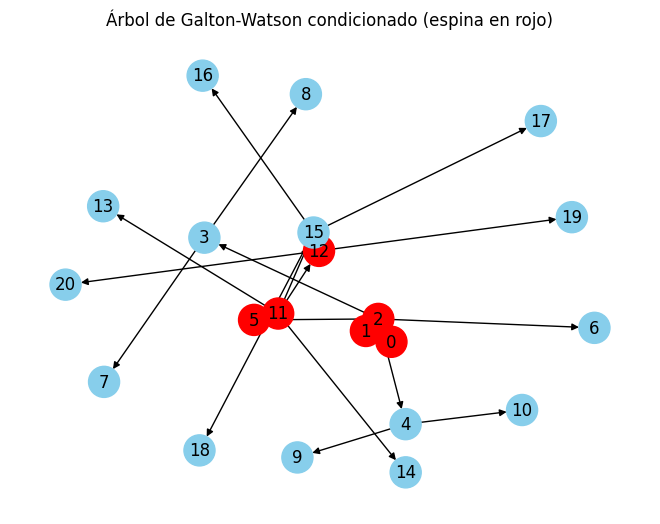

In [7]:
tree = generate_gw_tree_with_spine(max_depth=6)
draw_tree(tree)

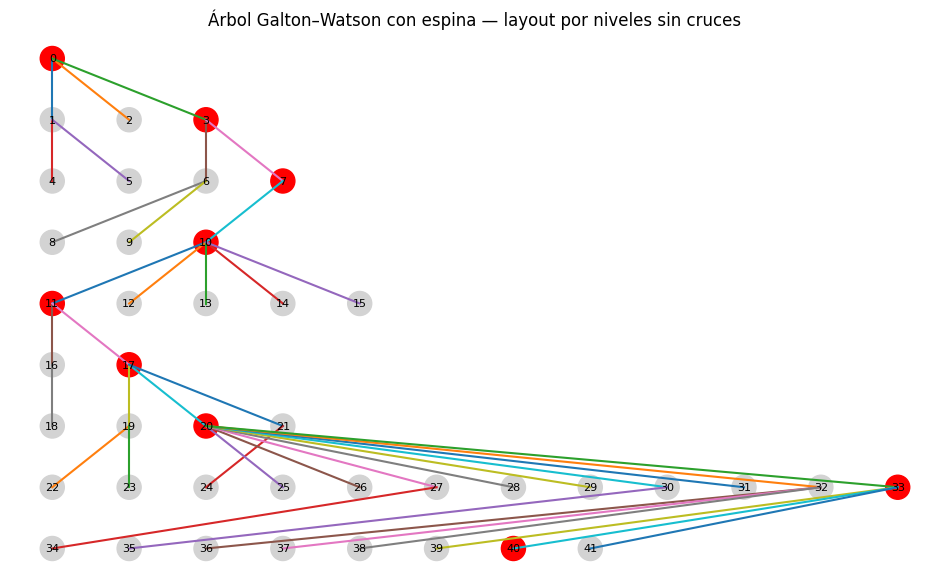

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# -------- Muestreos --------
def sample_pk_geometric(rng):
    # pk = 1/2^{k+1}, k>=0  => Geometric(0.5) - 1
    return rng.geometric(0.5) - 1

def sample_rhok_size_biased(rng):
    # rho_k = k / 2^{k+1}, k>=1  (usamos inversa de la CDF: F(n)=1-(n+2)/2^{n+1})
    u = rng.random()
    n = 1
    while True:
        if u <= 1 - (n + 2) / (2 ** (n + 1)):
            return n
        n += 1

# -------- Generación del árbol con espina + niveles con orden estable --------
def generate_gw_tree_with_spine_levels(max_depth=6, seed=42):
    rng = np.random.default_rng(seed)
    next_id = 0
    nodes = {next_id: {'depth': 0, 'spine': True}}; next_id += 1
    edges = []
    level_nodes = {0: [0]}      # dict: profundidad -> lista de nodos EN ORDEN
    current_root = 0

    for depth in range(max_depth):
        # aseguro listas para niveles siguientes
        level_nodes.setdefault(depth+1, [])
        level_nodes.setdefault(depth+2, [])

        # hijos del padre de la espina en este nivel (k ~ rho)
        k_sp = sample_rhok_size_biased(rng)
        spine_children = []
        for _ in range(k_sp):
            nid = next_id; next_id += 1
            nodes[nid] = {'depth': depth+1, 'spine': False}
            edges.append((current_root, nid))
            spine_children.append(nid)
            # *** orden estable: apendo en el orden de creación ***
            level_nodes[depth+1].append(nid)

        # si no hubo hijos, terminamos
        if not spine_children:
            break

        # elegimos nuevo padre de la espina y marcamos
        next_root = rng.choice(spine_children)
        nodes[next_root]['spine'] = True

        # los otros hijos generan nietos con pk; quedan contiguos y en orden
        for c in spine_children:
            if c == next_root:
                continue
            k = sample_pk_geometric(rng)
            for _ in range(k):
                nid = next_id; next_id += 1
                nodes[nid] = {'depth': depth+2, 'spine': False}
                edges.append((c, nid))
                level_nodes[depth+2].append(nid)

        current_root = next_root

    return nodes, edges, level_nodes

# -------- Dibujo sin cruces (por niveles y en orden) --------
def draw_tree_layered_noncross(nodes, edges, level_nodes):
    # posición x = índice en la lista ordenada del nivel; y = -profundidad
    pos = {}
    for d in sorted(level_nodes.keys()):
        for i, nid in enumerate(level_nodes[d]):
            pos[nid] = (i, -d)

    plt.figure(figsize=(12, 7))
    # aristas (entre niveles consecutivos; sin cruces por construcción)
    for u, v in edges:
        x1, y1 = pos[u]; x2, y2 = pos[v]
        plt.plot([x1, x2], [y1, y2])

    # nodos (espina en rojo)
    xs, ys, cols = [], [], []
    for nid, (x, y) in pos.items():
        xs.append(x); ys.append(y)
        cols.append('red' if nodes[nid].get('spine', False) else 'lightgray')
    plt.scatter(xs, ys, c=cols, s=300)
    for nid, (x, y) in pos.items():
        plt.text(x, y, str(nid), ha='center', va='center', fontsize=8)

    plt.title("Árbol Galton–Watson con espina — layout por niveles sin cruces")
    plt.axis('off')
    plt.show()

# ---- Demo
nodes, edges, level_nodes = generate_gw_tree_with_spine_levels(max_depth=8, seed=7)
draw_tree_layered_noncross(nodes, edges, level_nodes)


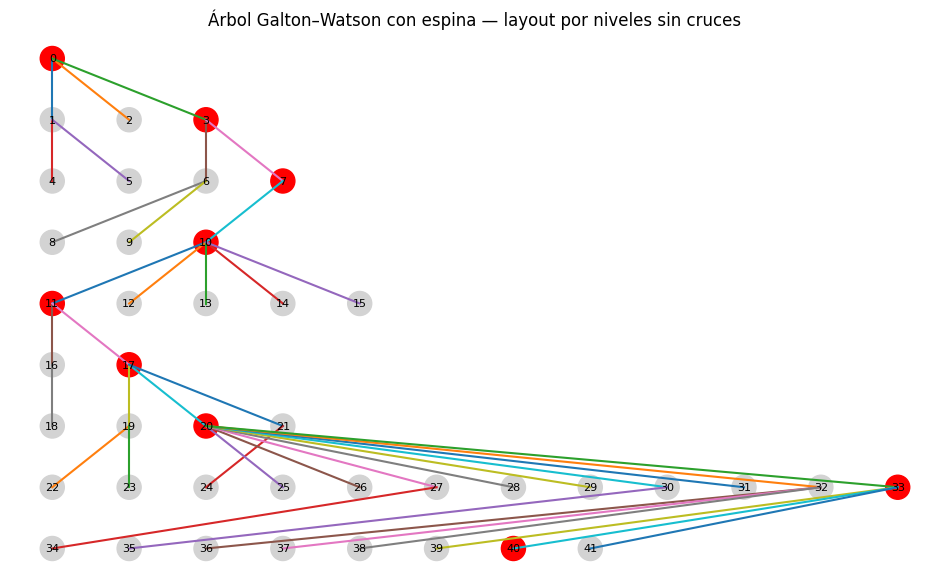

In [9]:
draw_tree_layered_noncross(nodes, edges, level_nodes)

In [10]:
!pip install graphviz

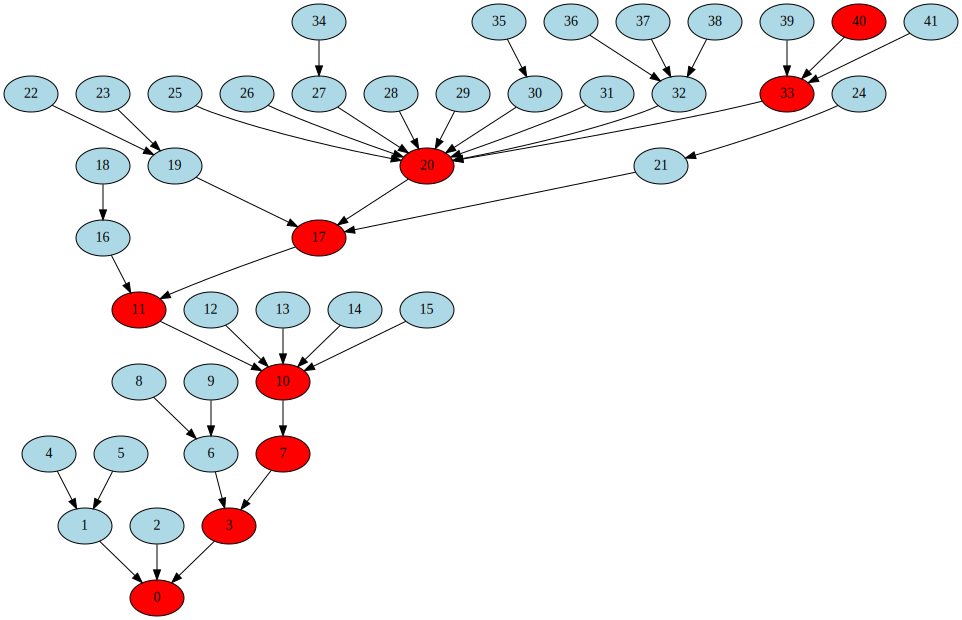

In [12]:
import graphviz

def draw_tree_graphviz(nodes, edges, reverse_edges=False):
    dot = graphviz.Digraph(comment='Galton-Watson Tree with Spine', strict=True) # strict=True helps prevent parallel edges

    # Add nodes with color based on spine property
    for nid, data in nodes.items():
        color = 'red' if data.get('spine', False) else 'lightblue'
        dot.node(str(nid), label=str(nid), style='filled', fillcolor=color)

    # Add edges
    for u, v in edges:
        if reverse_edges:
            dot.edge(str(v), str(u)) # Reverse the edge direction
        else:
            dot.edge(str(u), str(v))

    # Render the graph
    display(dot)

# Draw the tree using graphviz with reversed edges
draw_tree_graphviz(nodes, edges, reverse_edges=True)